# It is worth to watch this video:
https://www.youtube.com/watch?v=zkgm0i77jQ8

### GT explanation

Spectral Clustering:
no assumption about the shape of the clusters
No iterative process for the local minimum

Process: 
Create a Similarity Graph for all the data - here we can use for example a KNN method
Spectral Embedding: Embed data in a low-dimensional data space, where the clusters will be more obvious, with the use of eigenvectoers of graph Laplacian: Adjacency Matrix (n*n) with wij which is the weight of the ij edge, D Degree Matrix (sum of weights by row into the diagonal). L = D-A : Lij = di if i=j, -wij if (i,j) is an edge, 0 where there is no edge
Classical algorithm (usually k-means) is applied to partition the embedding

For Matrix A lambda is an eigenvalue if for some vector Av = lambdav
and v is the eigenvector

For G graph, if it has n nodes, its adjecency has n eigenvalues and corresponding eigenvecors. Let assume: Mu1>=Mu2>-...Mun we call it the spectrum of the graph
L has the same number of eigenvalues: 0 = Lambda1<=Lambda2<=....Lambdan

These Eigenvalues tells us lots of secretes:
e.g. if 0 = Lambda1=Lambda2=...Lambdak it means that G has k connected components

If the Graph Connected, then Lambda2 >0. The greater is lambda2 the more connected is G

Bipartiotioning vua Spectral Methods: take the Lambda2 > the smaller the better the partitioning
Let be v2 the corresponding eigenvector: For each node i in G we assign the v2(i).
C1 and C2 clusters: C1 where v2(i)>0 and C2 where v2(i)<0

EXTENSION TO k partitions: 
Lnorm = power(D,-1/2)Lpower(D,-1/2)
v1, v2, ... vk, first k eigen vectors of Lnorm
from these vectors as column create the U matrix

Each row will be a feature vector of the ith point of the graph after normalising.
Cluster it with k-means into C1,....Ck

### Algorithm

The algorithm can be broken down into 4 basic steps.
- Construct a similarity graph
- Determine the Adjacency matrix W, Degree matrix D and the Laplacian matrix L
- Compute the eigenvectors of the matrix L
- Using the second smallest eigenvector as input, train a k-means model and use it to classify the data

In [10]:
import numpy as np
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter}) # to have only 3 digit rounding - nicer
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
sns.set()

# GT EXAMPLE
- Sammy,Meany,Fatty,TallWhite,HisWife,MiniMe,LittleSon,Bg1,Bg2,Bg3,Bg4,Bg5 are 12 people.
- The next graph is their adjecency matrix which shows if they know each other
- E.g. Sammy knows Meany,Fatty,TallWhite,Bg1,Bg3 and Bg5
- MiniMe knows TallWhite,HisWife and LittleSon
- Of course everyone knows themself

In [2]:
X = np.array([
    [1,1,1,1,0,0,0,1,0,1,0,1],
[1,1,1,1,0,0,0,0,0,0,0,0],
[1,1,1,1,0,0,0,0,0,0,0,0],
[1,1,1,1,1,1,1,1,1,1,0,0],
[0,0,0,1,1,1,1,0,0,0,0,0],
[0,0,0,1,1,1,1,0,0,0,0,0],
[0,0,0,1,1,1,1,0,0,0,0,0],
[1,0,0,1,0,0,0,1,1,1,0,0],
[0,0,0,1,0,0,0,1,1,1,0,0],
[1,0,0,1,0,0,0,1,1,1,0,0],
[0,0,0,0,0,0,0,0,0,0,1,1],
[1,0,0,0,0,0,0,0,0,0,1,1]
])
X

array([[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

In [23]:
def draw_graph(G):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=500)
    nx.draw_networkx_labels(G, pos,font_size =16)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

[[1 1 1 1 0 0 0 1 0 1 0 1]
 [1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 0 0 0 0 0]
 [0 0 0 1 1 1 1 0 0 0 0 0]
 [0 0 0 1 1 1 1 0 0 0 0 0]
 [1 0 0 1 0 0 0 1 1 1 0 0]
 [0 0 0 1 0 0 0 1 1 1 0 0]
 [1 0 0 1 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1]
 [1 0 0 0 0 0 0 0 0 0 1 1]]


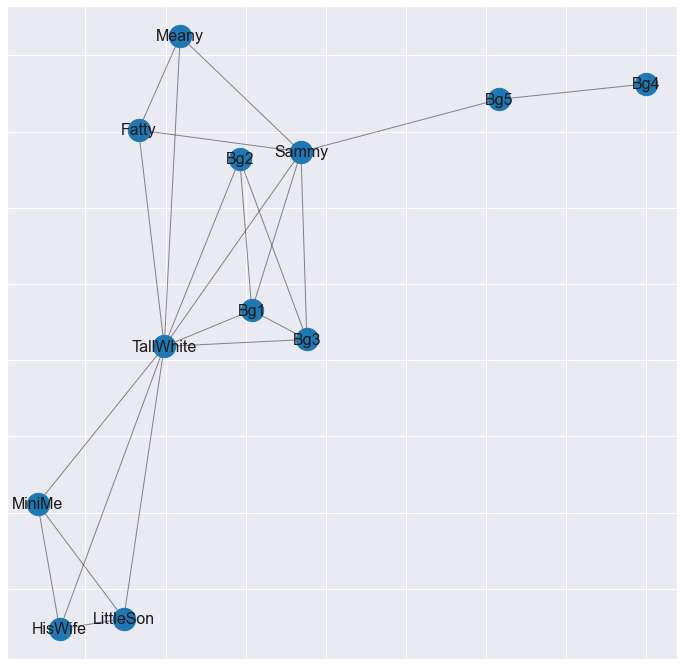

In [25]:
G = nx.from_numpy_matrix(X) # from adjecenct matrix this is the G Graph

# sorted(G)
# These are the names of the different nodes
mapping = {0:'Sammy',1:'Meany',2:'Fatty',3:'TallWhite',4:'HisWife',5:'MiniMe',6:'LittleSon',7:'Bg1',
               8:'Bg2',9:'Bg3',10:'Bg4',11:'Bg5'}
H = nx.relabel_nodes(G, mapping) # I apply the new names
plt.figure(figsize=(12,12))
draw_graph(H)
W = nx.adjacency_matrix(H)
print(W.todense())

In [6]:
# degree matrix
D = np.diag(np.sum(np.array(W.todense()), axis=1))
print('degree matrix:')
print(D)
# laplacian matrix
L = D - W
print('laplacian matrix:')
print(L)

degree matrix:
[[ 7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  3]]
laplacian matrix:
[[ 6 -1 -1 -1  0  0  0 -1  0 -1  0 -1]
 [-1  3 -1 -1  0  0  0  0  0  0  0  0]
 [-1 -1  3 -1  0  0  0  0  0  0  0  0]
 [-1 -1 -1  9 -1 -1 -1 -1 -1 -1  0  0]
 [ 0  0  0 -1  3 -1 -1  0  0  0  0  0]
 [ 0  0  0 -1 -1  3 -1  0  0  0  0  0]
 [ 0  0  0 -1 -1 -1  3  0  0  0  0  0]
 [-1  0  0 -1  0  0  0  4 -1 -1  0  0]
 [ 0  0  0 -1  0  0  0 -1  3 -1  0  0]
 [-1  0  0 -1  0  0  0 -1 -1  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1 -1]
 [-1  0  0  0  0  0  0  0  0  0 -1  2]]


In [11]:
e, v = np.linalg.eig(L)
# eigenvalues
print('eigenvalues:')
print(e)
# eigenvectors
print('eigenvectors:')
print(v)

eigenvalues:
[10.017 7.129 0.000 0.383 1.048 1.769 2.510 4.144 5.000 4.000 4.000 4.000]
eigenvectors:
[[0.140 -0.874 0.289 0.002 -0.209 -0.116 0.121 -0.248 0.000 0.000 0.000
  0.000]
 [0.101 0.180 0.289 0.081 -0.242 -0.515 -0.167 0.123 -0.000 0.471 -0.601
  0.186]
 [0.101 0.180 0.289 0.081 -0.242 -0.515 -0.167 0.123 0.000 -0.471 0.601
  -0.186]
 [-0.946 -0.051 0.289 0.128 -0.021 -0.003 -0.036 -0.016 0.000 -0.000
  0.000 -0.000]
 [0.105 0.008 0.289 0.208 0.441 0.004 0.024 0.005 0.000 0.607 0.430
  -0.193]
 [0.105 0.008 0.289 0.208 0.441 0.004 0.024 0.005 -0.000 -0.353 -0.205
  -0.565]
 [0.105 0.008 0.289 0.208 0.441 0.004 0.024 0.005 -0.000 -0.254 -0.224
  0.758]
 [0.100 0.250 0.289 0.097 -0.261 0.309 -0.003 -0.414 -0.707 0.000 0.000
  0.000]
 [0.106 -0.109 0.289 0.123 -0.278 0.499 -0.087 0.738 0.000 -0.000 -0.000
  -0.000]
 [0.100 0.250 0.289 0.097 -0.261 0.309 -0.003 -0.414 0.707 0.000 0.000
  0.000]
 [0.002 -0.029 0.289 -0.764 0.200 0.099 -0.529 -0.043 0.000 -0.000 -0.000
  0.000]
 [

Only one eigen value is 0, which means it's a connected matrix. If it wasn't we had at least 2 0 eigen value
Let's see an example:

### EXAMPLE TO SEE NOT CONNECTED MATRIX

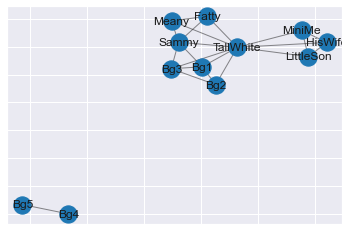

In [8]:
X2 = np.array([
    [1,1,1,1,0,0,0,1,0,1,0,0],
[1,1,1,1,0,0,0,0,0,0,0,0],
[1,1,1,1,0,0,0,0,0,0,0,0],
[1,1,1,1,1,1,1,1,1,1,0,0],
[0,0,0,1,1,1,1,0,0,0,0,0],
[0,0,0,1,1,1,1,0,0,0,0,0],
[0,0,0,1,1,1,1,0,0,0,0,0],
[1,0,0,1,0,0,0,1,1,1,0,0],
[0,0,0,1,0,0,0,1,1,1,0,0],
[1,0,0,1,0,0,0,1,1,1,0,0],
[0,0,0,0,0,0,0,0,0,0,1,1],
[0,0,0,0,0,0,0,0,0,0,1,1]
])
G2 = nx.from_numpy_matrix(X2)
sorted(G2)
mapping = {0:'Sammy',1:'Meany',2:'Fatty',3:'TallWhite',4:'HisWife',5:'MiniMe',6:'LittleSon',7:'Bg1',
               8:'Bg2',9:'Bg3',10:'Bg4',11:'Bg5'}
H2 = nx.relabel_nodes(G2, mapping)
draw_graph(H2)
W2 = nx.adjacency_matrix(H2)
#print(W2.todense())

In [12]:
# degree matrix
D2 = np.diag(np.sum(np.array(W2.todense()), axis=1))
#print('degree matrix:')
#print(D)
# laplacian matrix
L2 = D2 - W2
#print('laplacian matrix:')
#print(L2)

e2, v2 = np.linalg.eig(L2)
# eigenvalues
print('eigenvalues:')
print(e2)
# eigenvectors
#print('eigenvectors:')
#print(v2)

eigenvalues:
[10.000 6.236 4.000 -0.000 1.000 1.764 5.000 4.000 4.000 4.000 2.000 0.000]


now we have 2 0 eigenvalues!!
### END OF EXAMPLE!

[[0.002]
 [0.081]
 [0.081]
 [0.128]
 [0.208]
 [0.208]
 [0.208]
 [0.097]
 [0.123]
 [0.097]
 [-0.764]
 [-0.471]]


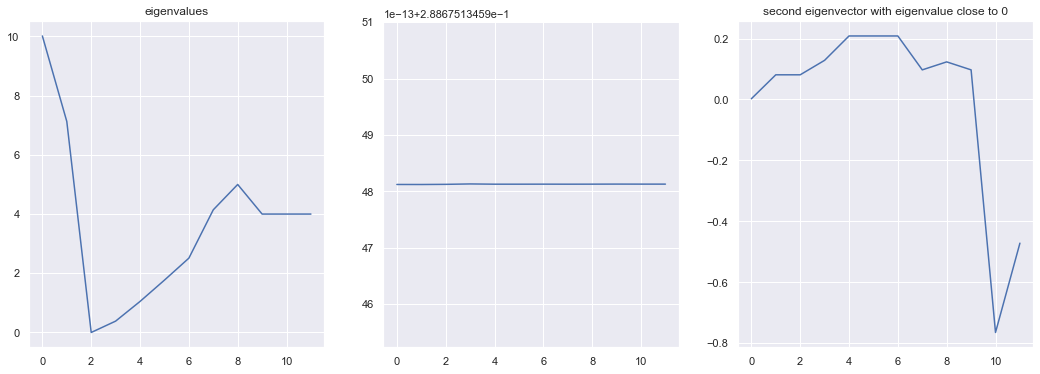

In [13]:
fig = plt.figure(figsize=[18, 6])
ax1 = plt.subplot(131)
plt.plot(e)
ax1.title.set_text('eigenvalues')
i = np.where(e < 0.5)[0]
ax2 = plt.subplot(132)
plt.plot(v[:, i[0]])
ax3 = plt.subplot(133)
plt.plot(v[:, i[1]])
ax3.title.set_text('second eigenvector with eigenvalue close to 0')
print(v[:, i[1]])

In [14]:
U = np.array(v[:, i[1]])
km = KMeans(init='k-means++', n_clusters=2)
km.fit(U)
km.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

### as we can see, the last too nodes go to different cluster

In [35]:
np.where(e < 1.1)

(array([2, 3, 4], dtype=int64),)

### 3 clusters

[[0.002 -0.209]
 [0.081 -0.242]
 [0.081 -0.242]
 [0.128 -0.021]
 [0.208 0.441]
 [0.208 0.441]
 [0.208 0.441]
 [0.097 -0.261]
 [0.123 -0.278]
 [0.097 -0.261]
 [-0.764 0.200]
 [-0.471 -0.010]]


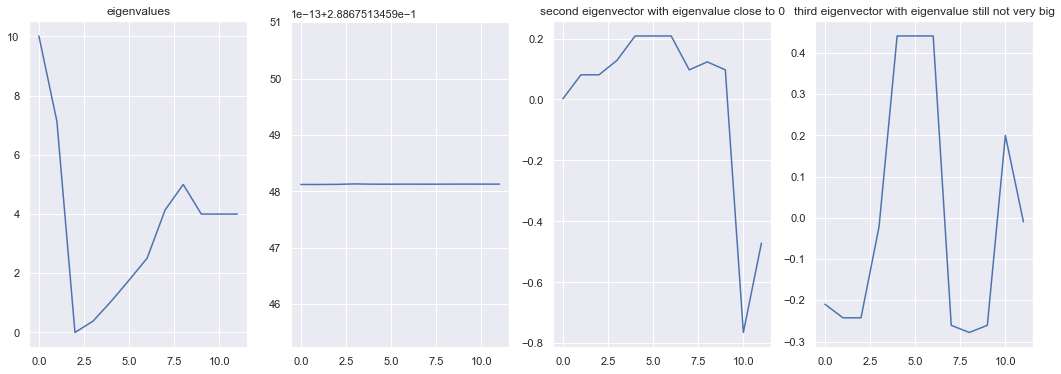

In [34]:
# for this we need the 3 smallest one
fig = plt.figure(figsize=[18, 6])
ax1 = plt.subplot(141)
plt.plot(e)
ax1.title.set_text('eigenvalues')
i = np.where(e < 1.1)[0]
ax2 = plt.subplot(142)
plt.plot(v[:, i[0]])
ax3 = plt.subplot(143)
plt.plot(v[:, i[1]])
ax3.title.set_text('second eigenvector with eigenvalue close to 0')
ax4 = plt.subplot(144)
plt.plot(v[:, i[2]])
ax4.title.set_text('third eigenvector with eigenvalue still not very big')
print(v[:, [i[1],i[2]]])

In [35]:
U = np.array(v[:, [i[1],i[2]]])
km = KMeans(init='k-means++', n_clusters=3)
km.fit(U)
km.labels_

array([1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 0])

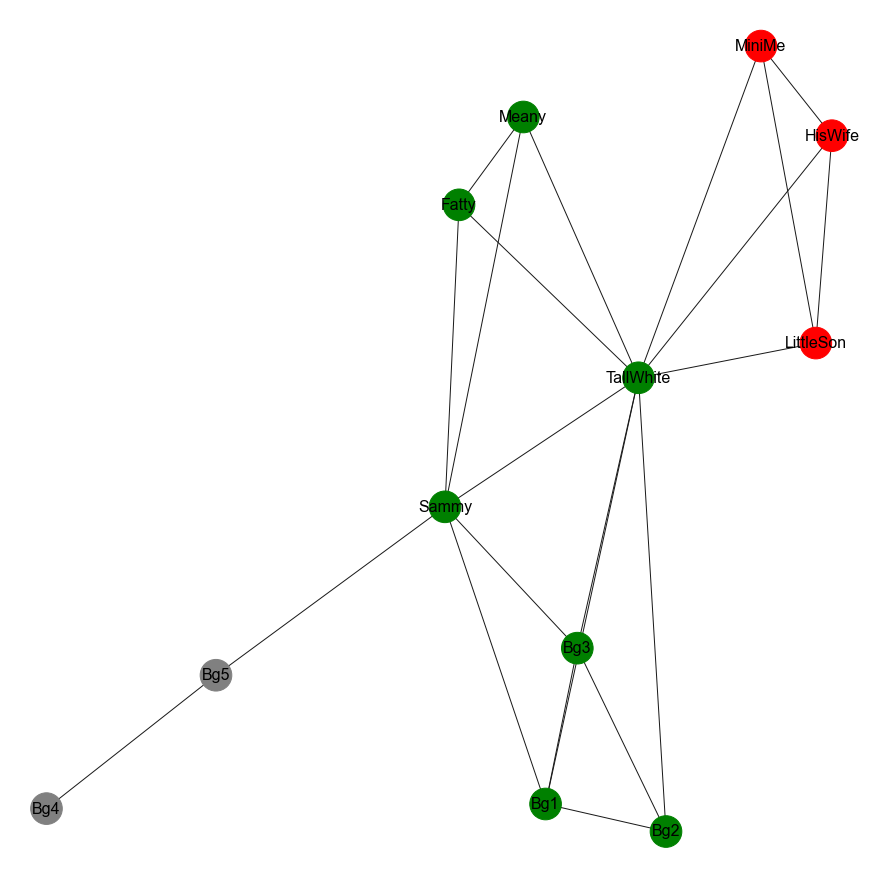

In [52]:
colors = ['grey','green','red']
#fcolors = ['red', 'black', 'black']
color_map = []
fcolor_map = []
for node in G:
    color_map.append(colors[km.labels_[node]])
    #fcolor_map.append(fcolors[km.labels_[node]])
plt.figure(figsize=(12,12))
nx.draw(H, node_color=color_map, with_labels=True, font_size=16 ,node_size = 1000,font_color = 'black' )  